In [1]:
import math
import itertools

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import einops as E

In [2]:
import torch
import os

m_gpu=0
os.environ['CUDA_VISIBLE_DEVICES'] = '%d' % m_gpu
torch.cuda.set_device(m_gpu)
torch.cuda.is_available()
torch.cuda.current_device()
device = torch.device(torch.cuda.current_device())
print("device now: ", device)

device now:  cuda:0


In [3]:
from universeg import universeg
model = universeg(pretrained=True)
_ = model.to(device)

In [4]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))
    
    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)
    
    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
    
    if title:
        plt.suptitle(title, fontsize=20)
            
    plt.tight_layout()

In [5]:
from example_data.wbc import WBCDataset

d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_support = 48

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device) # [48,1,128,128]
support_labels = torch.stack(support_labels).to(device) # [48,1,128,128]

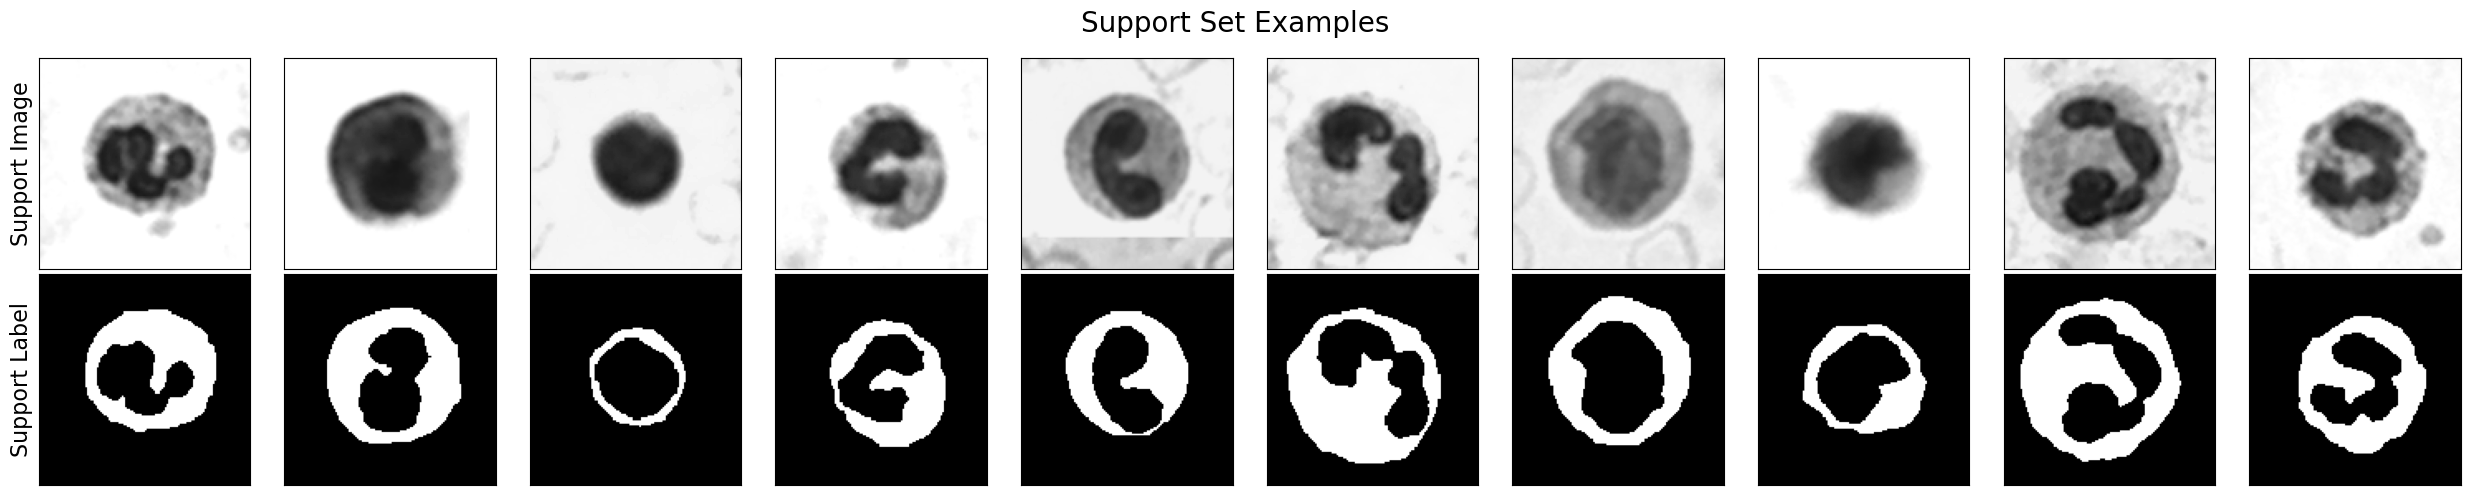

In [6]:
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples')

In [7]:
# select an image, label test pair
idx = np.random.permutation(len(d_test))[0]
image, label = d_test[idx]
image, label = image.to(device), label.to(device)

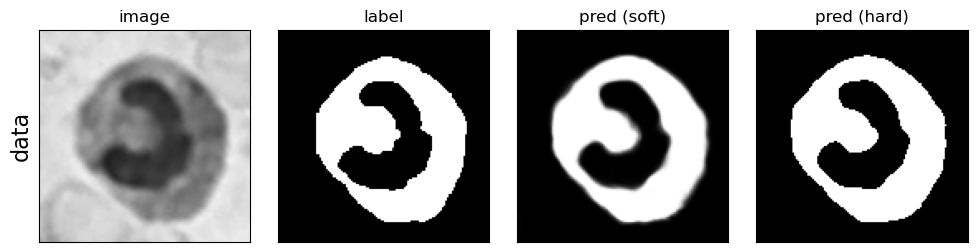

In [8]:
# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)

# visualize
res = {'data': [image, label, pred, pred > 0.5]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)

In [9]:
import example_data.oasis
d_support = example_data.oasis.OASISDataset('support', label=1)
d_test = example_data.oasis.OASISDataset('test', label=1)

support_images, support_labels = zip(*itertools.islice(d_support, 10))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

In [10]:
support_images.size()

torch.Size([10, 1, 128, 128])

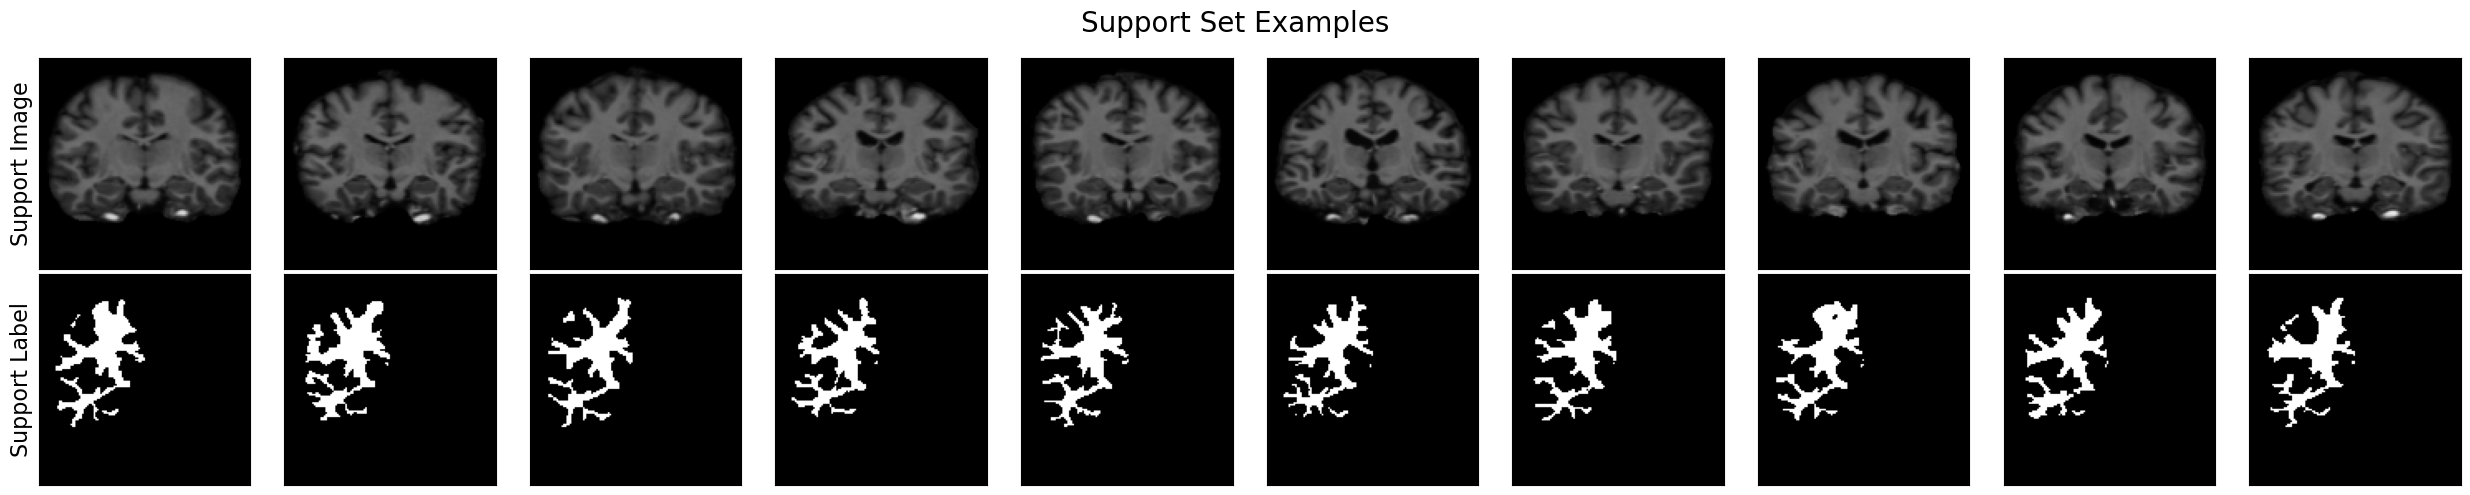

In [11]:
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples')

In [12]:
# select an image, label test pair
idx = np.random.permutation(len(d_test))[0]
image, label = d_test[idx]
image, label = image.to(device), label.to(device)

In [13]:
# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)

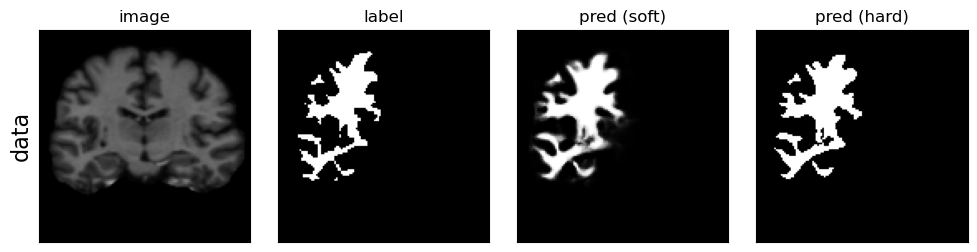

In [14]:
# visualize
res = {'data': [image, label, pred, pred > 0.5]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)